____
__Universidad Tecnológica Nacional, Buenos Aires__\
__Ingeniería Industrial__\
__Autor: Rodrigo Maranzana__\
__Cátedra de Investigación Operativa - Curso I4051 - Turno Miércoles Noche - Docente: Martín Palazzo__
____

# Ejemplo de planificación de la producción

## Introducción
Se busca optimizar el plan de producción para el año siguiente. Desde el sector comercial se proveen las proyecciones de demanda mensual. 

Por otro lado, el departamento de Ingeniería de planta nos provee todos los parámetros correspondientes a la capacidad instalada. Nos informan, además, que en Diciembre se realiza el mantenimiento preventivo y no podrá producirse.

Ingeniería de procesos cuenta con información sobre la cadencia media de los empleados. 

Por último, desde el sector de RRHH nos envían información sobre el personal, suspensiones, costos asociados y nuevas reglamentaciones como la imposibilidad de despedir empleados.

## Descripción del modelo

Se trabaja con un horizonte temporal de un año divido en meses. El modelo fue simplificado de forma didáctica.

Se busca minimizar el funcional de la sumatoria mensual de todos los costos incurridos en el año:
$$
Min \ Z = \sum_t{[cpn*PN_t + cpe*PE_t  + ci*I_t + cdn*DN_t + cds*DS_t + cdc*DC_t + cq*Q_t]} \\
$$


Sujeto a las restricciones:

- Balance productivo:
$$
PN_t + PE_t + I_{t-1} + Q_t = d_t + I_t \ ; \ \forall t \\
$$

- Imposibilidad de producción por mantenimiento preventivo:
$$
PN_{12}, PE_{12} = 0 \\
$$

- Límites de horas productivas normales y extra:
$$
\alpha * PN_t \leq wnMax * DN_t \\
\alpha * PE_t \leq weMax * DN_t \\
$$

- Balance de personal:
$$
DN_t + DS_t = DN_{t-1} + DS_{t-1} + DC_t \ ; \ \forall t \\
$$

- Límite máximo de inventario:
$$
I_t \leq iMax \ ; \ \forall t \\
$$

- Cotas de personal trabajando:
$$
dMin \leq DN_t \leq dMax \ ; \ \forall t \\
$$

- Positividad:
$$
PN_t, PE_t, I_t, DN_t, DS_t, DC_t, Q_t \geq 0
$$

- Variables enteras:
$$
DN_t, DS_t, DC_t \in Z
$$

Donde las variables: 
$PN_t$, $PE_t$ son la producción normal y extra del mes $t$; 
$I_t$ es el nivel de inventario del mes $t$; 
$DN_t$, $DS_t$ y $DC_t$ es la dotación normal, suspendida y contratada en el mes $t$; 
$Q_t$ es la cantidad tercerizada en el mes $t$.

Y los parámetros:
$d_t$ es la cantidad demandada en el mes $t$;
$cpn$ y $cpe$, son el costo de producir una unidad en horas normales y extra;
$ci$ el costo de mantener inventario;
$cdn$, $dcs$ y $cdc$, son el costo por personal trabajando, suspendido y contratado;
$cq$, es el costo por tercerizar;
$wnMax$ y $weMax$, son la cantidad maxima de horas normales y extra que puede trabajar una persona, por mes;
$iMax$, es la cantidad máxima de inventario;
$dMin$ y $dMax$, son la dotación trabajando máxima y mínima;

## Modelo en PuLP

In [1]:
import pulp

Creamos un problema lineal (LpProblem) de PuLP. Indicamos que vamos a minimizar el objetivo mediante LpMinimize

In [2]:
lp = pulp.LpProblem("planificacion", pulp.LpMinimize)

### Sets:
Creamos "Sets", que son simplemente los índices en los cuales se van a mover las variables. En este caso tenemos un solo set de tiempo con índices mensuales. es decir:
$$ t = \{1, 2, 3, ..., 10, 11, 12\} $$

In [3]:
t_set = list(range(1, 13))
t_set

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

### Parámetros
Ingresamos los parámetros que van a ser constantes o diccionarios de constantes ya definidos o ajustados previamente.

En primer lugar, definimos la demanda como un diccionario de Python. Cada clave del diccionario corresponde a un mes, y cada valor a la demanda. 

Usamos este tipo de objeto porque es el que acepta PuLP para poder tener parámetros que dependen de un set. Es decir, si quiero la demanda en el mes 3, simplemente puedo llamar a $d[3]$.

In [4]:
##### Demanda ######
d = {1: 60_000, 2: 50_000, 3: 70_000, 4: 90_000, 5: 380_000, 6: 420_000,\
     7: 120_000, 8: 60_000, 9: 50_000, 10: 35_000, 11: 40_000, 12: 65_000}

El resto de los parámetros son constantes y tienen que ver con: las horas de producción, inventarios, costos y dotación del personal.

In [5]:
##### Horas de producción ###
alfa   = 0.04 # Horas invertidas por unidad.
w_nmax = 160 # Horas normales que puede trabajar una persona por mes.
w_emax = 64 # Horas extras máximas que puede trabajar una persona por mes.

##### Inventario #####
i_max = 25_000 # Inventario máximo.
i_0   = 300 # Inventario mínimo inicial (t=1)

##### Costos #####
c_pn = 66 # Costo productivo en horas normales.
c_pe = 74 # Costo productivo en horas extra.
c_q  = 240 # Costo por tercerizar.
c_dn = 120 # Costo sueldos normales
c_ds = c_dn * 0.6 # costo sueldos suspendidos
c_dc = 50 # Costo por contratar
c_i  = 10 # Costo por mantenimiento de inventario.

#### Dotación #####
d_min = 10 # Dotación mínima.
d_max = 20 # Dotación máxima.
d_0   = 10 # Dotación inicial normal.
d_s0  = 0 # Suspendidos inicialmente.

### Variables
Creamos variables usando el método "LpVariable" de PuLP. Pero además, las definimos como diccionarios de variables, ya que existirá una por cada índice del set definido arriba, es decir, por cada mes.

Por ejemplo, la variable que define la producción del mes 4 puedo llamarla invocando $P[4]$.

Las variables continuas que vamos a crear son: Producción normal, producción extra, nivel de inventario y nivel de tercerización. Por otro lado, no podemos escapar a ciertas variables enteras, como son: personal trabajando, personal contratado ese mes y personal suspendido.

En este momento, también podemos crear cotas máximas y mínimas para las variables usando los parámetros definidos más arriba. Como la dotación máxima y mínima que puede trabajar. Otra forma de hacer esto, es definirlo como una restricción.

In [6]:
P_N = pulp.LpVariable.dicts('P_N', t_set, 0, None, cat='Continuous') # Producción normal
P_E = pulp.LpVariable.dicts('P_E', t_set, 0, None, cat='Continuous') # Producción extra
I   = pulp.LpVariable.dicts('I'  , t_set, 0, i_max, cat='Continuous')  # Inventario
Q   = pulp.LpVariable.dicts('Q'  , t_set, 0, None, cat='Continuous')   # Tercerización
D_N = pulp.LpVariable.dicts('D_N', t_set, d_min, d_max, cat='Continuous') # Personal trabajando
D_C = pulp.LpVariable.dicts('D_C', t_set, 0, None, cat='Integer')  # Personal contratado
D_S = pulp.LpVariable.dicts('D_S', t_set, 0, None, cat='Integer')  # Personal suspendido

### Función objetivo
La función objetivo es una suma de todas las variables en sus índices mensuales. PuLP incorpora el método "lpSum(<list>)" para poder sumar variables que fueron definidas como diccionarios.
    
En primer lugar creamos una lista, en donde cada elemento es el costo total incurrido en un mes $t$. Luego, aplicamos el método "lpSum" esa lista y lo sumamos al modelo.

In [7]:
Z = [c_pn * P_N[t] + c_pe * P_E[t] + c_i * I[t] + c_dc * D_C[t] + \
     c_dn * D_N[t] + c_ds * D_S[t] + c_q * Q[t] for t in t_set]
lp += pulp.lpSum(Z), 'Z'

### Restricciones

Al estar trabajando con un set de meses, existen restricciones que se repiten por cada uno de ellos. Por lo tanto, vamos a tener que iterar la creación de las restricciones y agregar una por cada mes, en el caso que corresponda.

#### Balance productivo:
Es el balance entre la produccion, el inventario y la tercerización del mes siguiente y el anterior. Es decir la suma de estas tres cosas en un mes posterior tiene que dar lo mismo que en un mes anterior.

Lo que explicamos anteriormente sobre iterar en restricciones, sucede con esta en particular. Sin embargo, también debemos crear una restricción adicional para el caso del mes 1. Ya que su balance se compensa con lo sobrante del año anterior y la restricción se escribe de forma diferente.


In [8]:
lp += P_N[1] + P_E[1] + i_0 + Q[1] == d[1] + I[1] # para t='1'

for t in t_set[1:]: 
    lp += P_N[t] + P_E[t] + I[t-1] + Q[t] == d[t] + I[t] # para t=[2,12]

#### Restricción de producción en Diciembre:
Por mantenimiento preventivo no se puede producir en diciembre:

In [9]:
lp += P_N[12] == 0
lp += P_E[12] == 0

#### Límites de horas productivas:
En este caso no vamos a comparar meses, sino establecer una cota máxima de horas de trabajo. Esto está definido únicamente por la cantidad de personal. Cada empleado trabaja la misma cantidad de horas y al mismo ritmo.

In [10]:
for t in t_set: 
    lp += alfa * P_N[t] <= D_N[t] * w_nmax
for t in t_set: 
    lp += alfa * P_E[t] <= D_N[t] * w_emax

#### Balance de personal:

Es el balance de un mes posterior y uno anterior entre el personal trabajando, el personal suspendido y las contrataciones. Para el primer mes, hacemos lo mismo que con el balance de producción, es decir, crear una restricción adicional.

In [11]:
lp += D_N[1] + D_S[1] == d_0 + d_s0 + D_C[1] # para t='1'
for t in t_set[1:]: 
    lp += D_N[t] + D_S[t] == D_N[t-1] + D_S[t-1] + D_C[t] # para t=[2,12]

### Solución

Resolvemos el modelo de PuLP usando el método .solve()

In [12]:
lp.solve()

1

Imprimimos el status del problema y el valor óptimo de la función objetivo.

In [13]:
print(pulp.LpStatus[lp.status])
print(pulp.value(lp.objective))

Optimal
200826404.0


Imprimimos el valor de cada variable. Para lograr esto, debemos iterar cada variable en el set de meses.

In [14]:
for variable in lp.variables():
    print(f"{variable.name:s} = {variable.varValue:.2f}")

D_C_1 = 5.00
D_C_10 = 0.00
D_C_11 = 0.00
D_C_12 = 0.00
D_C_2 = 0.00
D_C_3 = 4.00
D_C_4 = 1.00
D_C_5 = 0.00
D_C_6 = 0.00
D_C_7 = 0.00
D_C_8 = 0.00
D_C_9 = 0.00
D_N_1 = 15.00
D_N_10 = 10.00
D_N_11 = 17.00
D_N_12 = 10.00
D_N_2 = 13.00
D_N_3 = 19.00
D_N_4 = 20.00
D_N_5 = 20.00
D_N_6 = 20.00
D_N_7 = 20.00
D_N_8 = 15.00
D_N_9 = 13.00
D_S_1 = 0.00
D_S_10 = 10.00
D_S_11 = 3.00
D_S_12 = 10.00
D_S_2 = 2.00
D_S_3 = 0.00
D_S_4 = 0.00
D_S_5 = 0.00
D_S_6 = 0.00
D_S_7 = 0.00
D_S_8 = 5.00
D_S_9 = 7.00
I_1 = 0.00
I_10 = 0.00
I_11 = 25000.00
I_12 = 0.00
I_2 = 0.00
I_3 = 3000.00
I_4 = 25000.00
I_5 = 0.00
I_6 = 0.00
I_7 = 0.00
I_8 = 0.00
I_9 = 0.00
P_E_1 = 0.00
P_E_10 = 0.00
P_E_11 = 0.00
P_E_12 = 0.00
P_E_2 = 0.00
P_E_3 = 0.00
P_E_4 = 32000.00
P_E_5 = 32000.00
P_E_6 = 32000.00
P_E_7 = 32000.00
P_E_8 = 0.00
P_E_9 = 0.00
P_N_1 = 59700.00
P_N_10 = 35000.00
P_N_11 = 65000.00
P_N_12 = 0.00
P_N_2 = 50000.00
P_N_3 = 73000.00
P_N_4 = 80000.00
P_N_5 = 80000.00
P_N_6 = 80000.00
P_N_7 = 80000.00
P_N_8 = 60000.00
P_

## Resultados gráficos

In [15]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

Creamos listas con los valores mensuales de las variables para poder hacer plots de MatPlotLib.

In [16]:
result_P = [pn.varValue + pe.varValue for pn, pe in zip(P_N.values(), P_E.values())]
result_PE = [pe.varValue for pe in P_E.values()]
result_I = [i.varValue for i in I.values()]
result_Q = [q.varValue for q in Q.values()]
result_D = [dotn.varValue + dots.varValue for dotn, dots in zip(D_N.values(), D_S.values())]
result_DS = [dot.varValue for dot in D_S.values()]

### Nivel de producción mensual

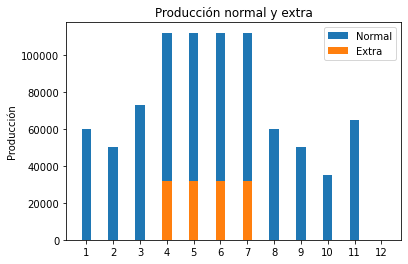

In [17]:
p_chart = plt.bar(t_set, result_P, 0.35)
pe_chart = plt.bar(t_set, result_PE, 0.35)
plt.ylabel('Producción')
plt.title('Producción normal y extra')
plt.legend((p_chart[0], pe_chart[0]), ('Normal', 'Extra'))
plt.xticks(range(1,13))
plt.show()

### Nivel de inventario

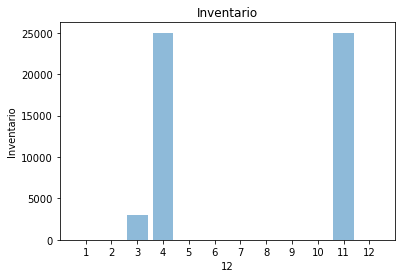

In [18]:
plt.bar(t_set, result_I, align='center', alpha=0.5)
plt.xlabel('%s' % t)
plt.ylabel('%s' % 'Inventario')
plt.title('%s' % 'Inventario')
plt.xticks(range(1,13))
plt.show()

### Nivel de tercerización

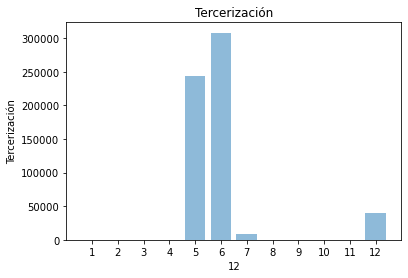

In [19]:
plt.bar(t_set, result_Q, align='center', alpha=0.5)
plt.xlabel('%s' % t)
plt.ylabel('%s' % 'Tercerización')
plt.title('%s' % 'Tercerización')
plt.xticks(range(1,13))
plt.show()

### Personal

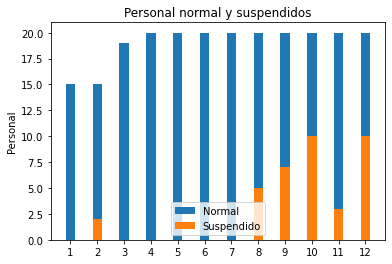

In [20]:
d_chart = plt.bar(t_set, result_D, 0.35, zorder=1)
ds_chart = plt.bar(t_set, result_DS, 0.35, zorder=2)
plt.ylabel('Personal')
plt.title('Personal normal y suspendidos')
plt.legend((d_chart[0], ds_chart[0]), ('Normal', 'Suspendido'), loc="lower center")
plt.xticks(range(1,13))
plt.show()